# Converting SMPL model to keypoints and save as videos

In [105]:
from pathlib import Path
import pandas as pd
import pickle

%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import smplx
from tqdm import tqdm
import torch
import cv2

sys.path.append("../")
from smpl2motorica.utils.bvh import BVHParser
from smpl2motorica.utils.pymo.preprocessing import MocapParameterizer
from IPython.display import display_html 

In [106]:
def get_SMPL_skeleton_names():
    return [
        "pelvis",
        "left_hip",
        "right_hip",
        "spine1",
        "left_knee",
        "right_knee",
        "spine2",
        "left_ankle",
        "right_ankle",
        "spine3",
        "left_foot",
        "right_foot",
        "neck",
        "left_collar",
        "right_collar",
        "head",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
    ]
def get_motorica_skeleton_names():
    return [
        "Head",
        "Hips",
        "LeftArm",
        "LeftFoot",
        "LeftForeArm",
        "LeftHand",
        "LeftLeg",
        "LeftShoulder",
        # "LeftToeBase",
        "LeftUpLeg",
        "Neck",
        "RightArm",
        "RightFoot",
        "RightForeArm",
        "RightHand",
        "RightLeg",
        "RightShoulder",
        # "RightToeBase",
        "RightUpLeg",
        "Spine",
        "Spine1",
    ]
def smpl2motorica():
    return [
        "head",
        "spine1",
        "left_shoulder",
        "left_ankle",
        "left_elbow",
        "left_wrist",
        "left_knee",
        "left_collar",
        "left_hip",
        "neck",
        "right_shoulder",
        "right_ankle",
        "right_elbow",
        "right_wrist",
        "right_knee",
        "right_collar",
        "right_hip",
        "spine2",
        "spine3"
    ]
# append x, y, z rotation to each joint
def expand_skeleton(skeleton: list):
    expanded_skeleton = [f"{joint}_{axis}rotation" for joint in skeleton for axis in ['X', 'Y', 'Z']]
    return expanded_skeleton

def motorica_draw_stickfigure3d(
    fig,
    mocap_track,
    frame,
    data=None,
    joints=None,
    draw_names=True,
):
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(111, projection="3d")
    # ax.view_init(elev=0, azim=120)

    if joints is None:
        joints_to_draw = mocap_track.skeleton.keys()
    else:
        joints_to_draw = joints

    if data is None:
        df = mocap_track.values
    else:
        df = data

    for idx, joint in enumerate(joints_to_draw):
        # ^ In mocaps, Y is the up-right axis
        parent_x = df["%s_Xposition" % joint][frame]
        parent_y = df["%s_Zposition" % joint][frame]
        parent_z = df["%s_Yposition" % joint][frame]

        # parent_x = df["%s_Xposition" % joint][frame]
        # parent_y = df["%s_Yposition" % joint][frame]
        # parent_z = df["%s_Zposition" % joint][frame]

        ax.scatter(xs=parent_x, ys=parent_y, zs=parent_z, alpha=0.6, c="b", marker="o")
        

        children_to_draw = [
            c for c in mocap_track.skeleton[joint]["children"] if c in joints_to_draw
        ]

        for c in children_to_draw:
            # ^ In mocaps, Y is the up-right axis
            child_x = df["%s_Xposition" % c][frame]
            child_y = df["%s_Zposition" % c][frame]
            child_z = df["%s_Yposition" % c][frame]

            ax.plot(
                [parent_x, child_x],
                [parent_y, child_y],
                [parent_z, child_z],
                # "k-",
                lw=2,
                c="black",
            )

        if draw_names:
            ax.text(
                x=parent_x - 0.01,
                y=parent_y - 0.01,
                z=parent_z -0.01,
                s=f"{idx}:{joint}",
                fontsize=5,
            )

    return ax


def SMPL_output_video(joints, vertices, model):
    for i in tqdm(range(joints.shape[0]), desc="Generating SMPL video"):
        fig = plt.figure(figsize=(10, 10))
        ax = SMPL_visulize_a_frame(fig, joints[i], vertices[i], model)
        ax.set_title(f"SMPL frame {i}")
        plt.savefig(f"smpl_frame_{i:04d}.png")
        plt.close(fig)
    
    # compile the video
    image_folder = '.'
    video_name = 'smpl_video.mp4'
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fps = 6 # Set frames per second
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    # remove the images
    for image in images:
        os.remove(os.path.join(image_folder, image))
    
    return video_name

def SMPL_visulize_a_frame(fig, joints, vertices, model, output_name="test.png"):
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection

    ax = fig.add_subplot(111, projection="3d")
    # ax.view_init(elev=0)
    mesh = Poly3DCollection(vertices[model.faces], alpha=0.01)
    face_color = (1.0, 1.0, 0.9)
    edge_color = (0, 0, 0)
    mesh.set_edgecolor(edge_color)
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], color="r")
    # ax.set_xlim([-1, 1])
    # ax.set_ylim([-1, 1])
    # ax.set_zlim([-1, 1])
    joint_names = get_SMPL_skeleton_names()
    for i, joint in enumerate(joints):
        ax.text(
            joint[0],
            joint[1],
            joint[2],
            f"{i}:{joint_names[i]}",
            color="blue",
            fontsize=5,
        )
    ax.view_init(elev=0, azim=180)
    return ax


## Load Dummy Motorica data

In [107]:
motorica_data_root = Path("./data/motorica_dance_dataset")
motorica_motion_path = (
    motorica_data_root
    / "bvh"
    / "kthjazz_gCH_sFM_cAll_d02_mCH_ch01_beatlestreetwashboardbandfortyandtight_003.bvh"
)
if not motorica_motion_path.exists():
    raise FileNotFoundError(f"Motion file {motorica_motion_path} does not exist. ")
bvh_parser = BVHParser()
motorica_dummy_data = bvh_parser.parse(motorica_motion_path)

# # Filter out unnecessary columns
# joints_to_keep = get_motorica_skeleton_names()
# expand_joints_to_keep = expand_skeleton(joints_to_keep)
# # append location to the joint names
# expand_joint_with_location = ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition'] + expand_joints_to_keep
# # filter out unnecessary joints

In [115]:
skeleton_list = sorted(list(motorica_dummy_data.skeleton.keys()))
skeleton_list

['Head',
 'Head_Nub',
 'Hips',
 'LeftArm',
 'LeftFoot',
 'LeftForeArm',
 'LeftHand',
 'LeftHandIndex1',
 'LeftHandIndex2',
 'LeftHandIndex3',
 'LeftHandIndex3_Nub',
 'LeftHandMiddle1',
 'LeftHandMiddle2',
 'LeftHandMiddle3',
 'LeftHandMiddle3_Nub',
 'LeftHandPinky1',
 'LeftHandPinky2',
 'LeftHandPinky3',
 'LeftHandPinky3_Nub',
 'LeftHandRing1',
 'LeftHandRing2',
 'LeftHandRing3',
 'LeftHandRing3_Nub',
 'LeftHandThumb1',
 'LeftHandThumb2',
 'LeftHandThumb3',
 'LeftHandThumb3_Nub',
 'LeftLeg',
 'LeftShoulder',
 'LeftToeBase',
 'LeftToeBase_Nub',
 'LeftUpLeg',
 'Neck',
 'RightArm',
 'RightFoot',
 'RightForeArm',
 'RightHand',
 'RightHandIndex1',
 'RightHandIndex2',
 'RightHandIndex3',
 'RightHandIndex3_Nub',
 'RightHandMiddle1',
 'RightHandMiddle2',
 'RightHandMiddle3',
 'RightHandMiddle3_Nub',
 'RightHandPinky1',
 'RightHandPinky2',
 'RightHandPinky3',
 'RightHandPinky3_Nub',
 'RightHandRing1',
 'RightHandRing2',
 'RightHandRing3',
 'RightHandRing3_Nub',
 'RightHandThumb1',
 'RightHandTh

In [97]:
# scale the skeleton
def skeleton_scaler(skeleton, ratio):
    for joint in skeleton:
        skeleton[joint]["offsets"] = np.array(skeleton[joint]["offsets"]) * ratio
    return skeleton

ratio = 0.01
motorica_dummy_data.skeleton = skeleton_scaler(motorica_dummy_data.skeleton, ratio)


## Loading SMPL model from the aist dataset

In [98]:
amass_data_root = Path("./data/AIST++/gBR_sBM_cAll_d04_mBR0_ch01.pkl")
smpl_model_path = Path("./smpl/models")
if not amass_data_root.exists():
    raise FileNotFoundError(f"AMASS data root {amass_data_root} does not exist. ")
if not smpl_model_path.is_dir():
    raise FileNotFoundError(f"SMPL model path {smpl_model_path} does not exist. ")


# load the data
data = np.load(amass_data_root, allow_pickle=True)
print(data.keys())
# sample every 10 frames
sample_indices = np.arange(0, data["smpl_poses"].shape[0], 10)
poses = data["smpl_poses"][sample_indices]
root_trans = data["smpl_trans"][sample_indices]
scale = data["smpl_scaling"]

smpl_model = smplx.create(
    model_path=smpl_model_path,
    model_type="smpl",
    return_verts=True,
    batch_size=len(poses),
)


dict_keys(['smpl_loss', 'smpl_poses', 'smpl_scaling', 'smpl_trans'])


In [99]:
smpl_body_pose = poses[:, 3:]

In [100]:



# joints:
# smpl_body_pose = poses[:, 3:66]
# smpl_root_rot = poses[:, :3]
smpl_body_pose = np.zeros_like(smpl_body_pose)
smpl_output = smpl_model(body_pose=torch.tensor(smpl_body_pose, dtype=torch.float32),
                        transl = torch.tensor(root_trans, dtype=torch.float32),
                        # global_orient = torch.tensor(smpl_root_rot, dtype=torch.float32),
                         )
smpl_joints_loc = smpl_output.joints.detach().cpu().numpy().squeeze()
smpl_vertices = smpl_output.vertices.detach().cpu().numpy().squeeze()

In [101]:
smpl_joints_loc = smpl_joints_loc[:, : 23,:]

In [102]:
smpl_joints_loc.shape

(72, 23, 3)

In [103]:
smpl_vertices.shape

(72, 6890, 3)

<Axes3D: >

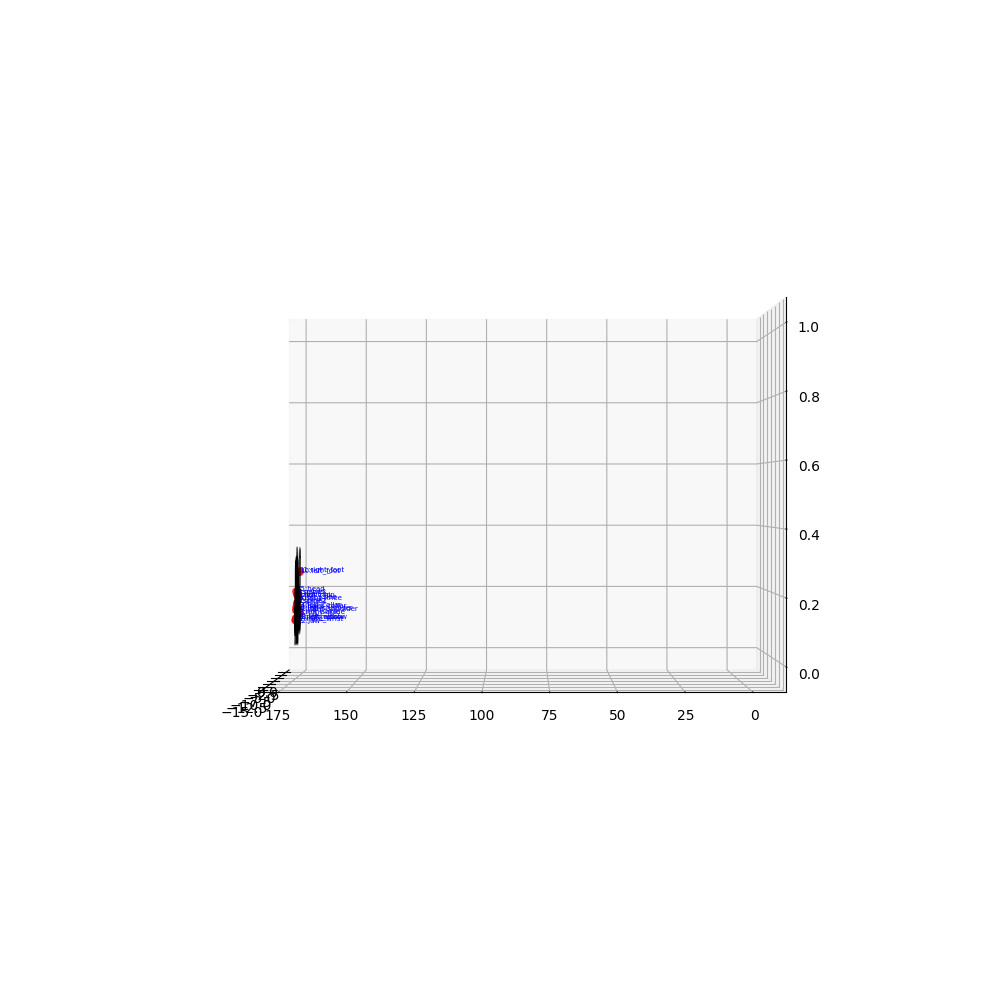

In [104]:
# visualize smpl
# visualize one frame
frame = 0
smpl_joint = smpl_joints_loc[frame]
smpl_vertices = smpl_vertices[frame]
fig = plt.figure(figsize=(10, 10))
ax = SMPL_visulize_a_frame(fig,smpl_joint, smpl_vertices, smpl_model)
ax

In [21]:
smpl_model.J_regressor.shape

torch.Size([55, 10475])

In [ ]:
# COCO plus regressor
coco_plus_regressor_path = Path("./data/neutral_smpl_with_cocoplus_reg.pkl")
with open(coco_plus_regressor_path, "rb") as f:
    coco_plus_regressor = pickle.load(f, encoding='latin1')

C:\Users\siyuan\AppData\Local\Temp\ipykernel_43868\676270690.py:4: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  coco_plus_regressor = pickle.load(f, encoding='latin1')


In [13]:
coco_plus_regressor.keys()


dict_keys(['J', 'weights_prior', 'posedirs', 'bs_style', 'v_template', 'cocoplus_regressor', 'J_regressor_prior', 'f', 'J_regressor', 'kintree_table', 'weights', 'bs_type', 'shapedirs'])

In [14]:
coco_plus_regressor['cocoplus_regressor'].shape

(19, 6890)

In [15]:
coco_plus_regressor['J_regressor'].shape

(24, 6890)

In [16]:
coco_plus_regressor['J'].shape

(24, 3)

<Axes3D: >

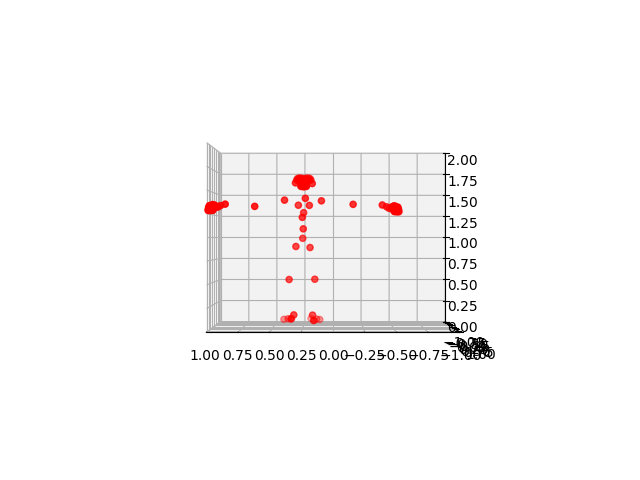

In [11]:
# # height of the skeleton
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# # ax.view_init(elev=0)
# ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], color="r")
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
# ax.set_zlim([0, 2])
# joint_names = get_SMPL_skeleton_names()
# # for i, joint in enumerate(joints):
# #     ax.text(
# #         joint[0],
# #         joint[1],
# #         joint[2],
# #         f"{i}:{joint_names[i]}",
# #         color="blue",
# #         fontsize=5,
# #     )
# ax.view_init(elev=0, azim=90)
# ax


In [97]:
# convert SMPL to Motorica Keypoint

# create a df for smpl joints
expanded_smpl_joint_names = expand_skeleton(get_SMPL_skeleton_names())
smpl_joints_df = pd.DataFrame(smpl_body_pose, columns=expanded_smpl_joint_names)
# get in motorica joint order
motorica_joint_names = expand_skeleton(smpl2motorica())


In [98]:
# reorder the columns
keypoint_smpl_df = smpl_joints_df[motorica_joint_names]
# convert from radian to degree and keep the same order
keypoint_smpl_df = keypoint_smpl_df.apply(np.rad2deg)
# rename the columns to motorica joint names
keypoint_smpl_df.columns = expand_skeleton(get_motorica_skeleton_names())


In [99]:
# add root position
root_pos_df = pd.DataFrame(root_trans, columns=["Hips_Xposition", "Hips_Yposition", "Hips_Zposition"])
# shuffle Y and Z axis while keeping the same order
root_pos_df = root_pos_df[["Hips_Xposition", "Hips_Zposition", "Hips_Yposition"]]
root_pos_df.columns = ["Hips_Xposition", "Hips_Yposition", "Hips_Zposition"]   
# reverse the direction of Y axis
root_pos_df["Hips_Zposition"] = -root_pos_df["Hips_Zposition"] 
# force the starting the position to be zero
root_pos_df = root_pos_df - root_pos_df.iloc[0]
# minutes offset for z position
z_offset = -0.7553
root_pos_df["Hips_Yposition"] = root_pos_df["Hips_Yposition"] - z_offset
# concate the root position
new_df = pd.concat([root_pos_df, keypoint_smpl_df], axis=1)
# # Add a dummy starting frame which is all zero
# new_df = pd.concat([pd.DataFrame(np.zeros((1, new_df.shape[1]), dtype=np.float32), columns=new_df.columns), new_df], axis=0)
# new_df.head()

In [100]:

# convert to joint position
motorica_dummy_data.values = new_df
position_mocap = MocapParameterizer("position").fit_transform([motorica_dummy_data])[0]
position_df = position_mocap.values
position_df.head()

,Hips_Xposition,Hips_Yposition,Hips_Zposition,RightUpLeg_Xposition,RightUpLeg_Yposition,RightUpLeg_Zposition,RightLeg_Xposition,RightLeg_Yposition,RightLeg_Zposition,RightFoot_Xposition,...,LeftHandThumb3_Nub_Zposition,Neck_Xposition,Neck_Yposition,Neck_Zposition,Head_Xposition,Head_Yposition,Head_Zposition,Head_Nub_Xposition,Head_Nub_Yposition,Head_Nub_Zposition
0,0.000000,0.755300,0.000000,-0.094871,0.755000,0.000853,-0.105209,0.400942,-0.044963,-0.110438,...,0.224059,0.001318,1.302395,0.080699,-0.003304,1.443598,0.125709,-0.003304,1.443598,0.125709
1,-0.000485,0.755399,-0.000669,-0.095347,0.754887,0.000825,-0.104338,0.401430,-0.049678,-0.107796,...,0.226598,-0.000445,1.301905,0.084240,-0.005243,1.442650,0.130646,-0.005243,1.442650,0.130646
2,-0.002681,0.755783,-0.001407,-0.097536,0.754767,0.000248,-0.102454,0.400365,-0.043777,-0.099449,...,0.231729,-0.005645,1.302245,0.083780,-0.010783,1.442750,0.130871,-0.010783,1.442750,0.130871
3,-0.007945,0.755763,-0.004056,-0.102811,0.754495,-0.003931,-0.103844,0.398453,-0.032153,-0.093604,...,0.247460,-0.013044,1.301566,0.084938,-0.018719,1.441760,0.132887,-0.018719,1.441760,0.132887
4,-0.015887,0.755278,-0.006562,-0.110750,0.753959,-0.007238,-0.111696,0.398106,-0.037748,-0.099638,...,0.277222,-0.021036,1.299106,0.093845,-0.026350,1.438112,0.145173,-0.026350,1.438112,0.145173


In [101]:
# # get left foot and right foot position
# foot_position = position_df[[ "LeftFoot_Zposition", "RightFoot_Zposition"]].iloc[0]
# avg_vertical_offset = np.mean(foot_position)
# avg_vertical_offset = -0.05469189744854054

In [102]:
# # apply this offset all joints' z position
# # position_df.values = position_df.values.loc[:, new_df.columns.str.contains('_Zposition')] += avg_vertical_offset
# # position_df.values
# position_df.loc[:, position_df.columns.str.contains('_Zposition')] -= avg_vertical_offset
# position_mocap.values = position_df

In [103]:
position_mocap.values.head()

,Hips_Xposition,Hips_Yposition,Hips_Zposition,RightUpLeg_Xposition,RightUpLeg_Yposition,RightUpLeg_Zposition,RightLeg_Xposition,RightLeg_Yposition,RightLeg_Zposition,RightFoot_Xposition,...,LeftHandThumb3_Nub_Zposition,Neck_Xposition,Neck_Yposition,Neck_Zposition,Head_Xposition,Head_Yposition,Head_Zposition,Head_Nub_Xposition,Head_Nub_Yposition,Head_Nub_Zposition
0,0.000000,0.755300,0.000000,-0.094871,0.755000,0.000853,-0.105209,0.400942,-0.044963,-0.110438,...,0.224059,0.001318,1.302395,0.080699,-0.003304,1.443598,0.125709,-0.003304,1.443598,0.125709
1,-0.000485,0.755399,-0.000669,-0.095347,0.754887,0.000825,-0.104338,0.401430,-0.049678,-0.107796,...,0.226598,-0.000445,1.301905,0.084240,-0.005243,1.442650,0.130646,-0.005243,1.442650,0.130646
2,-0.002681,0.755783,-0.001407,-0.097536,0.754767,0.000248,-0.102454,0.400365,-0.043777,-0.099449,...,0.231729,-0.005645,1.302245,0.083780,-0.010783,1.442750,0.130871,-0.010783,1.442750,0.130871
3,-0.007945,0.755763,-0.004056,-0.102811,0.754495,-0.003931,-0.103844,0.398453,-0.032153,-0.093604,...,0.247460,-0.013044,1.301566,0.084938,-0.018719,1.441760,0.132887,-0.018719,1.441760,0.132887
4,-0.015887,0.755278,-0.006562,-0.110750,0.753959,-0.007238,-0.111696,0.398106,-0.037748,-0.099638,...,0.277222,-0.021036,1.299106,0.093845,-0.026350,1.438112,0.145173,-0.026350,1.438112,0.145173


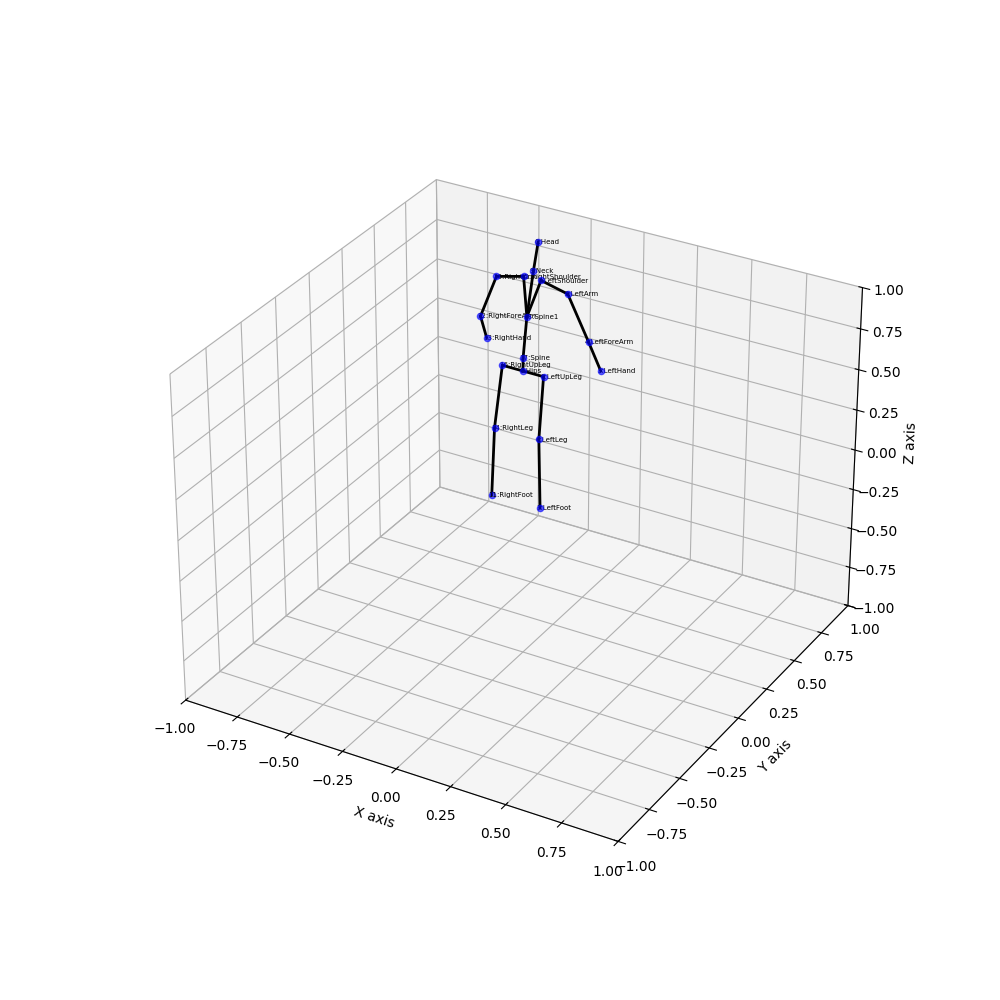

In [104]:
# visualize a frame
frame = 0
fig = plt.figure(figsize=(10, 10))
motorica_ax = motorica_draw_stickfigure3d(
            fig=fig,
            mocap_track=position_mocap, frame=frame, joints=get_motorica_skeleton_names(), draw_names=True
        )
motorica_ax.set_xlabel('X axis')
motorica_ax.set_ylabel('Y axis')
motorica_ax.set_zlabel('Z axis')
motorica_ax.set_zlim([-1, 1])
motorica_ax.set_xlim([-1, 1])
motorica_ax.set_ylim([-1, 1])
# motorica_ax.view_init(elev=0, azim=0)
plt.show()


In [105]:
# def save_video(df: pd.DataFrame):
#     import matplotlib.animation as animation
#     from IPython.display import HTML

#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection="3d")
#     ax.set_zlim([-100, 100])
#     ax.set_xlim([-100, 100])
#     ax.set_ylim([-100, 100])
#     ax.view_init(elev=0, azim=120)

#     def update(frame):
#         ax.clear()
#         motorica_draw_stickfigure3d(
#             fig=fig,
#             mocap_track=df,
#             frame=frame,
#             joints=get_motorica_skeleton_names(),
#             draw_names=True,
#         )
#         ax.set_xlabel('X axis')
#         ax.set_ylabel('Y axis')
#         ax.set_zlabel('Z axis')
#         return ax

#     ani = animation.FuncAnimation(fig, update, frames=range(df.values.shape[0]))
#     ani.save("smpl2motorica.mp4", writer="ffmpeg", fps=30)
#     return ani
import cv2
import os
from tqdm import tqdm

def save_video(data):
    df = data.values
    image_folder = 'tmp'
    os.makedirs(image_folder, exist_ok=True)
    
    for frame in tqdm(range(len(df)), desc="Generating Videos"):
        fig = plt.figure(figsize=(10, 10))
        motorica_ax = motorica_draw_stickfigure3d(
            fig=fig,
            mocap_track=data, frame=frame, joints=get_motorica_skeleton_names(), draw_names=True
        )
        motorica_ax.set_xlabel('X axis')
        motorica_ax.set_ylabel('Y axis')
        motorica_ax.set_zlabel('Z axis')
        motorica_ax.set_zlim([-1, 1])
        motorica_ax.set_xlim([-1, 1])
        motorica_ax.set_ylim([-1, 1])
        motorica_ax.view_init(elev=0, azim=0)
        motorica_ax.set_title(f"frame {frame}")
        plt.savefig(f"{image_folder}/frame_{frame:04d}.png")
        plt.close(fig)
    
    # compile the video
    video_name = 'smpl2motorica.mp4'
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fps = 12  # Set frames per second
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    
    # remove the images and directory
    for image in images:
        os.remove(os.path.join(image_folder, image))
    os.rmdir(image_folder)
    
    return video_name

Generating Videos:  53%|█████▎    | 31/59 [00:06<00:05,  4.92it/s]


KeyboardInterrupt: 

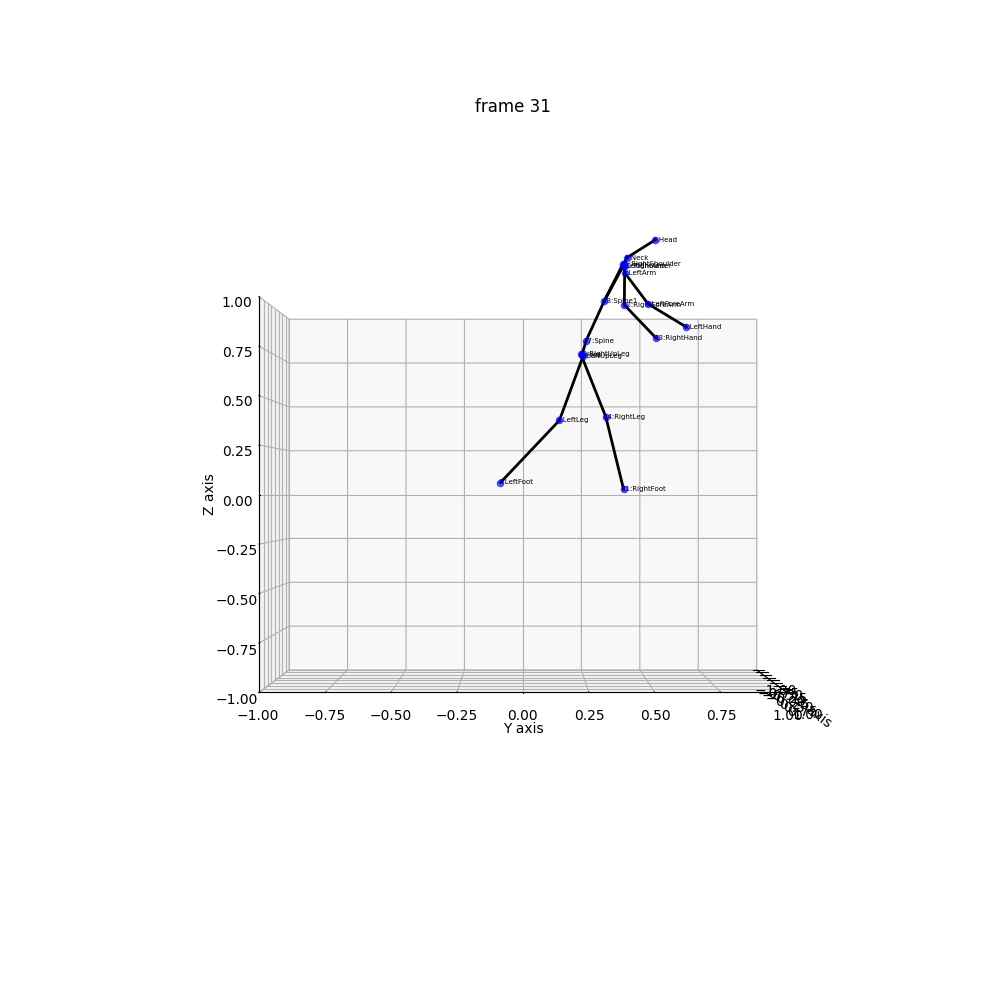

In [106]:
save_video(position_mocap)